### 案例：使用SVM进行人脸识别

### 下载数据
下面的方法免去了我们自己写代码读取图片存入numpy数组的过程。

如果使用其他Sklearn没有内置的数据集，则需要自己写代码读取图片数据并设置类别

In [1]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.data.shape)
print(faces.target_names)
print(faces.images.shape)

(1348, 2914)
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


### 画一些人脸，看看需要处理的数据

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
fig, ax = plt.subplots(3,5)
fig.subplots_adjust(left=0.0625, right=1.2, wspace=1)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])
plt.show()

<Figure size 640x480 with 15 Axes>

#### 使用预处理来提取更有意义的特征。这里使用主成份分析来提取150个基本元素，然后将其提供给支持向量机分类器。
#### 将这个预处理和分类器打包成管道

In [3]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf')
model = make_pipeline(pca, svc)

### 为了测试分类器的训练效果，将数据集分解成训练集和测试集进行交叉检验

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(faces.data, faces.target, random_state=42)

### 用网络搜索交叉检验来寻找最优参数组合。通过不断调整C（松弛变量）和参数gamma（控制径向基函数核的大小），确定最优模型

In [5]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1,5,10,50], 'svc__gamma':[0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

In [6]:
grid.fit(x_train, y_train)
print(grid.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'svc__C': 10, 'svc__gamma': 0.001}


### 有了交叉检验的模型，现在就可以对测试集的数据进行预测了

In [7]:
model = grid.best_estimator_
y_fit = model.predict(x_test)

### 比较预测结果和真实结果

Text(0.5,0.98,'预测错误的名字用红色标注')

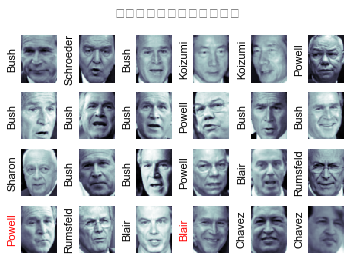

In [8]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(x_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_fit[i]].split()[-1],
                  color='black' if y_fit[i] == y_test[i] else 'red')
fig.suptitle('预测错误的名字用红色标注', size=14)

### 打印分类效果报告，他会列举每个标签的统计结果，从而对评估器的性能有更全面的认识

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_fit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.67      0.67        15
     Colin Powell       0.82      0.85      0.83        68
  Donald Rumsfeld       0.82      0.74      0.78        31
    George W Bush       0.89      0.87      0.88       126
Gerhard Schroeder       0.79      0.83      0.81        23
      Hugo Chavez       0.88      0.70      0.78        20
Junichiro Koizumi       0.92      0.92      0.92        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.82      0.82       337
     weighted avg       0.85      0.85      0.84       337



### 画出混淆矩阵，它可以帮助我们清晰的判断那些标签容易被分类器误判

Text(92.68,0.5,'predicted label')

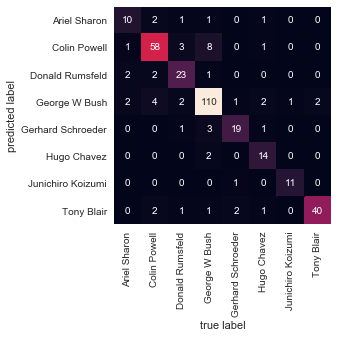

In [10]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')